In [1]:
import sys

sys.path.append('../src')

In [2]:
import numpy as np
import pcalg
import networkx as nx
from conditional_independence import partial_correlation_suffstat, partial_correlation_test
from mcmc.mcmc import PartitionMCMC
from mcmc.data import SyntheticDataset
from mcmc.proposals import PartitionProposal
from mcmc.scores import BGeScore

In [3]:
np.random.seed(21082024)

num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2
synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

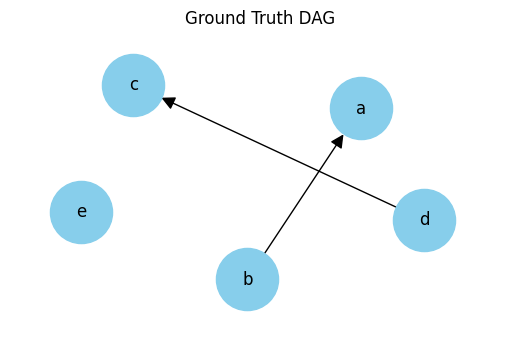

In [4]:
# visualise ground truth DAG
from mcmc.utils.graph_utils import plot_graph_from_adj_mat
plot_graph_from_adj_mat(synthetic_data.adj_mat.values, node_labels, title="Ground Truth DAG")

In [5]:
synthetic_data.data

,a,b,c,d,e
0,0.596567,0.366253,1.314119,1.638644,-1.267796
1,-0.111336,0.051585,-2.123218,-1.048295,-0.353849
2,0.231789,-0.633780,-1.311150,-1.048213,-1.756100
3,2.799811,1.315199,-1.534356,-2.650674,1.407939
4,1.732010,0.409359,1.819540,1.958708,-1.190838
...,...,...,...,...,...
195,-0.249165,0.360550,2.782336,2.261239,-1.091629
196,0.235041,-0.426940,-2.666748,-0.919500,-0.171046
197,-0.315555,-1.038597,-2.136058,-1.785052,0.503651
198,0.876527,0.954729,1.451935,0.923009,-1.596969


In [6]:
# setup mcmc
M = PartitionMCMC(max_iter=30000, data=synthetic_data.data, score_object='bge', pc_init=False)

In [7]:
# run experiment

mcmc_results, acceptance = M.run()
graphs = M.get_graphs(mcmc_results)
print('Acceptance_ratio:', acceptance)

Acceptance_ratio: 0.16516666666666666


In [16]:
from mcmc.utils.graph_utils import generate_key_from_adj_matrix

BURN_IN = 0.0

graphs = M.get_graphs(mcmc_results)

key = generate_key_from_adj_matrix(synthetic_data.adj_mat.values)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs[int(BURN_IN*len(graphs)):]], return_counts=True)
print(key in keys)

True


-1423.6925779237918


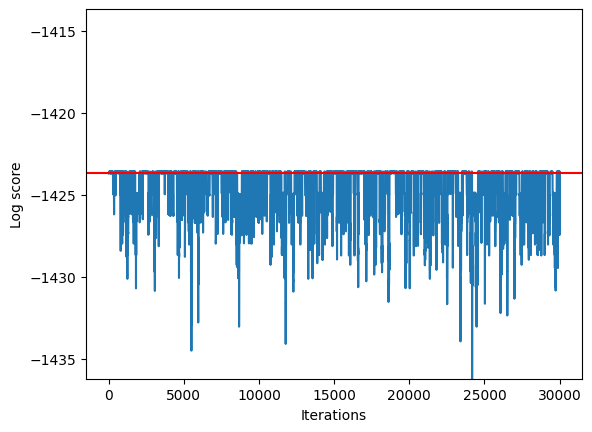

In [9]:
from mcmc.utils.partition_utils import convert_partition_to_party_permy_posy, build_partition
from mcmc.utils.score_utils import partition_score
from matplotlib import pyplot as plt

def get_mcmc_scores(results):
        mcmc_graph_lst = []
        for i in results:
            mcmc_graph_lst.append( results[i]['score_current'] )
        return mcmc_graph_lst
scores = get_mcmc_scores(mcmc_results)

true_partition = build_partition(incidence=synthetic_data.adj_mat.values, node_labels=list(synthetic_data.data.columns))
party_curr, permy_curr, posy_curr = convert_partition_to_party_permy_posy(true_partition)
true_score = partition_score(M.node_labels, M.node_labels, M.parent_table, M.score_table, permy_curr, party_curr, posy_curr )
true_score = sum(true_score['total_scores'].values())
plt.plot(range(len(scores)), scores)
plt.axhline(true_score, color='r')
plt.ylim(min(scores), true_score+10)
plt.xlabel('Iterations')
plt.ylabel('Log score')
print(true_score)

In [10]:
from mcmc.evaluation.metrics import kl_divergence, jensen_shannon_divergence, mean_squared_error, mean_absolute_error
from mcmc.inference.posterior import generate_all_dags_keys, generate_all_dags

all_dags = generate_all_dags(data=synthetic_data.data, my_score=BGeScore)


Total 5 node DAGs generated = 29281


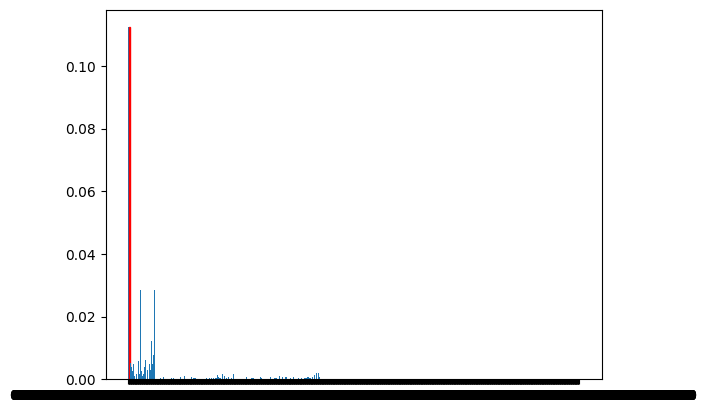

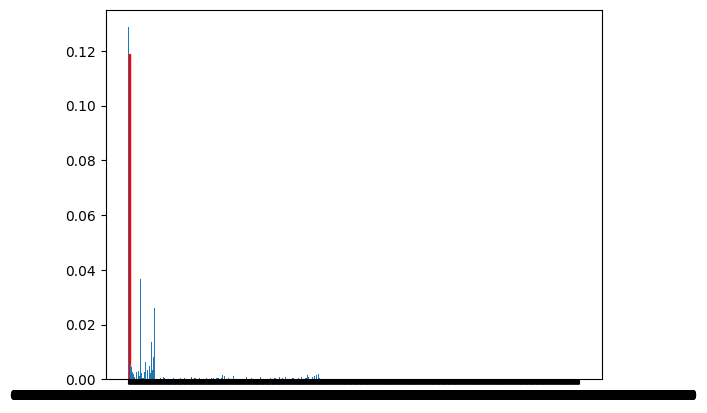

In [17]:

from mcmc.inference.posterior import compute_true_distribution

true_distribution = compute_true_distribution(all_dags)
dst = {key:count/sum(counts) for key, count in zip(keys, counts)}
approx_distribution = {key: (dst[key] if key in dst else 0) for key in true_distribution.keys()}

threshold = 1e-5
k = list(true_distribution.keys())
for _k in k:
    if true_distribution[_k] < threshold and approx_distribution[_k] < threshold:
        del true_distribution[_k]
        del approx_distribution[_k]
k = np.array(list(true_distribution.keys()))
bars = plt.bar(k, true_distribution.values())
# print(k, key)
bars[np.where(k==key)[0][0]].set_color('red')
plt.figure()
bars = plt.bar(approx_distribution.keys(), approx_distribution.values())
bars[np.where(k==key)[0][0]].set_color('red')

In [18]:
from mcmc.evaluation.metrics import mean_squared_error, mean_absolute_error, kl_divergence, jensen_shannon_divergence

print('KL div', kl_divergence(true_distribution, approx_distribution))
print('JS div', jensen_shannon_divergence(true_distribution, approx_distribution))
print('MSE', mean_squared_error(true_distribution, approx_distribution))
print('MAE', mean_absolute_error(true_distribution, approx_distribution))

KL div 0.35794211938306153
JS div 0.013815684552559326
MSE 6.978879488470796e-07
MAE 0.00015813455605129576
